<a href="https://colab.research.google.com/github/iamviji/project/blob/master/End2EndOneHotQPSK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 137 (delta 56), reused 16 (delta 2), pack-reused 0
Receiving objects: 100% (137/137), 4.58 MiB | 10.36 MiB/s, done.
Resolving deltas: 100% (56/56), done.
project  sample_data
MainModel.ipynb		     MainModelOneHotMethodSoftMax.ipynb
MainModelKeras.ipynb	     MainModelWithSingleBERTraining.ipynb
MainModelKerasOneHot.ipynb   README.md
MainModelModCoding.ipynb     util.py
MainModelOneHotMethod.ipynb
     |████████████████████████████████| 1.1MB 2.9MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=4dd6ba0db9395f0cf5923d33347f50ca8e7627368e82f1d32ce4fa2aaf2747a0
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |████████████████████████████████| 51kB 1.6MB/s 


In [2]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [4]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [5]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[1 1 1 ... 0 1 1]
 [1 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 1]
 ...
 [1 1 0 ... 0 1 1]
 [1 1 1 ... 0 1 1]
 [0 1 0 ... 1 0 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [6]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.88s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.73s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.67s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 7.23s
SNR: 0.000:
 -> BER: 0.61
 -> Total Time: 18.50s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.66s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 3.15s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.76s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 6.34s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 15.91s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.31s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.62s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.98s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 5.29s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 13.21s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.93s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [7]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.34s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.89s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.44s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.92s
SNR: 0.000:
 -> BER: 0.60
 -> Total Time: 14.60s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.24s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.43s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.70s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.88s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 12.25s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.15s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.11s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.08s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.21s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 10.55s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.88s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.83s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [8]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.43s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.87s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.34s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.00s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 14.65s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.26s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.57s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.89s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.25s
SNR: 0.500:
 -> BER: 0.57
 -> Total Time: 12.98s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.02s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.98s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.92s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 9.97s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.88s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.73s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

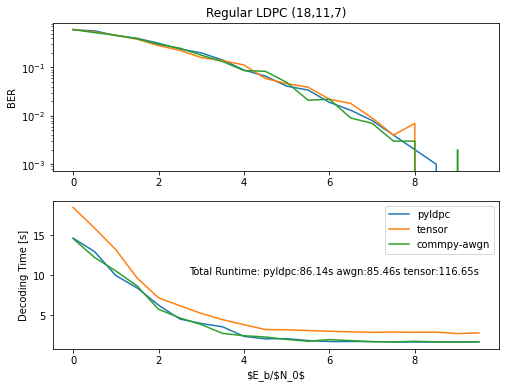

In [9]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [10]:
class GetOutOfLoop( Exception ):
    pass

In [18]:
# 18/9 = 2 bit per symbol => QSPK
num_of_channel = 9
input_message_length = 11
encoder_output_length = 18

In [24]:
# Define Model 
from keras.layers.normalization import BatchNormalization

# input_message_length is initialized by ldpc encoder

num_hidden_1 = encoder_output_length
print ("input_message_length=", input_message_length)

lr_x = tf.placeholder(dtype=tf.float32,shape=[])
#batch_size_x = tf.placeholder(tf.int32,shape=[])
input_message_x_label = tf.placeholder("int32", [None], name="input_message_x_label")
input_message_x = tf.placeholder("float32", [None, 2**input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, num_of_channel * 2], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1, num_of_channel * 2], -1, 1), name="encoder_l2_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_of_channel * 2, num_hidden_1], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1, num_hidden_1], -1, 1), name="decoder_l3_weights"),
  "decoder_l3" : tf.Variable (tf.random_uniform([num_hidden_1, 2**input_message_length], -1, 1), name="decoder_l3_weights"),
  
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_of_channel * 2], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="decoder_l2_bias"),
  "decoder_l3" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l3_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  #layer_2 = tf.round(layer_1)
  #layer_1 = BatchNormalization ()(layer_1)
  layer_3 =  layer_2 / tf.sqrt(tf.reduce_mean(tf.square(layer_2)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

def dl_decoder (x):
  layer_1 = (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.tanh(tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  layer_3 = (tf.matmul(layer_2, weights['decoder_l3']) + biases['decoder_l3'])
  return layer_3

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
loss = tf.losses.sparse_softmax_cross_entropy(labels=input_message_x_label,logits=dl_decoder_output)
optimizer = tf.train.AdamOptimizer(learning_rate=lr_x).minimize (loss)

input_message_length= 11


In [40]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE*10))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 2048)
(1, 10000)


In [33]:
batch_size = 500

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()
#0.8
epochs = 60
outer_ephocs = 1
display_step = 4
num_of_batches = training_input_message.shape[1] / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
snr_min = 9.5
snr_max = 10.5
snr_step_size = 0.5
max_iteration = epochs * num_of_batches * (snr_max - snr_min) / snr_step_size
print ("max iteration :",max_iteration,"num_of_batches:", num_of_batches)
try:
  for oe in range(outer_ephocs):
    for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
    #for snr in (numpy.arange (snr_min, snr_max, SNR_STEP_SIZE)):
      sigma = 1.0*Snr2Sigma (7)
      print ("Training for SNR=", snr, " sigma=", sigma, "iteratin:", oe) 
      for e in range(epochs):
        for j in range (int(num_of_batches)):
          i = i + 1
          x_train_batch_one_hot = training_input_message_one_hot [j*batch_size:(j+1)*batch_size]
          x_train_batch_one_hot = x_train_batch_one_hot.astype("float32")
          x_train_batch_label = training_input_message.reshape(training_input_message.shape[1]) [j*batch_size:(j+1)*batch_size]        
          if (i < 100): 
            lr = 0.1
          elif(i < 200):
            lr = 0.1
          else:
            lr = 0.01 
          _, l = train_sess.run ([optimizer, loss], feed_dict={input_message_x:x_train_batch_one_hot, awgn_noise_std_dev_x:sigma, lr_x:lr, input_message_x_label:x_train_batch_label.astype("int32")})
          if i % display_step == 0:          
            print('Step %i: Minibatch Loss: %f' % (i, l ))
          if (l < 0.05 and snr >= 9): 
            print ("Loss=", l)
            raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

Streaming output truncated to the last 5000 lines.
Step 4072: Minibatch Loss: 0.806507
Step 4076: Minibatch Loss: 0.809857
Step 4080: Minibatch Loss: 0.696921
Step 4084: Minibatch Loss: 0.722397
Step 4088: Minibatch Loss: 0.688128
Step 4092: Minibatch Loss: 0.783307
Step 4096: Minibatch Loss: 0.660790
Step 4100: Minibatch Loss: 0.761019
Step 4104: Minibatch Loss: 0.684827
Step 4108: Minibatch Loss: 0.709182
Step 4112: Minibatch Loss: 0.735016
Step 4116: Minibatch Loss: 0.676864
Step 4120: Minibatch Loss: 0.733126
Step 4124: Minibatch Loss: 0.732090
Step 4128: Minibatch Loss: 0.735339
Step 4132: Minibatch Loss: 0.710106
Step 4136: Minibatch Loss: 0.706844
Step 4140: Minibatch Loss: 0.791989
Step 4144: Minibatch Loss: 0.700092
Step 4148: Minibatch Loss: 0.689458
Step 4152: Minibatch Loss: 0.760456
Step 4156: Minibatch Loss: 0.746354
Step 4160: Minibatch Loss: 0.780158
Step 4164: Minibatch Loss: 0.748102
Step 4168: Minibatch Loss: 0.727855
Step 4172: Minibatch Loss: 0.752325
Step 4176: Mi

In [ ]:
awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [num_of_channel * 2])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

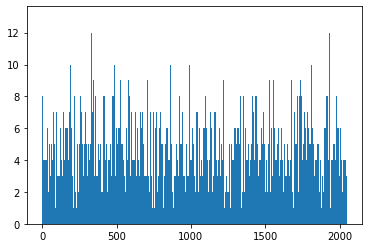

In [46]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
#training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
#y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message[0], bins = x_axis) 
plt.show()

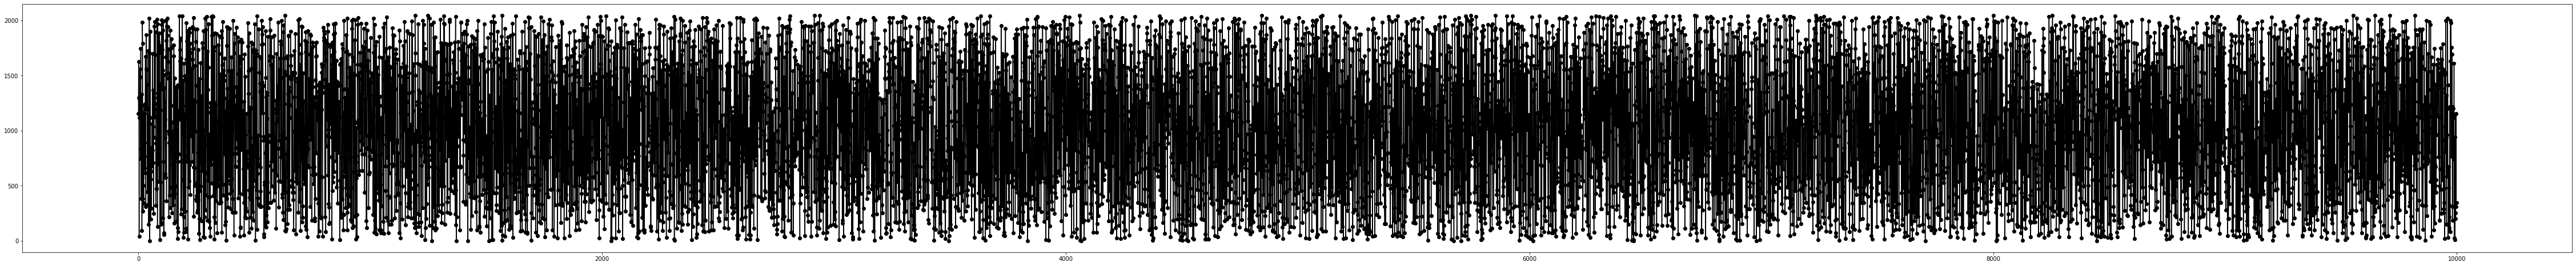

In [45]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:-1],training_input_message[0][:-1], '-ok')
#print (x_axis[:100])
#print(training_input_message_decimal[:100])

In [34]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []


for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    channel_in.append(encoded_message)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    channel_out.append(awgn_channel_output_message[0])
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.46s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.79s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.14s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.49s
SNR: 0.000:
 -> BER: 0.73
 -> Total Time: 3.88s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.34s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.65s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.98s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.30s
SNR: 0.500:
 -> BER: 0.66
 -> Total Time: 3.27s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.33s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.68s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.99s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.32s
SNR: 1.000:
 -> BER: 0.63
 -> Total Time: 3.32s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.32s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.63s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

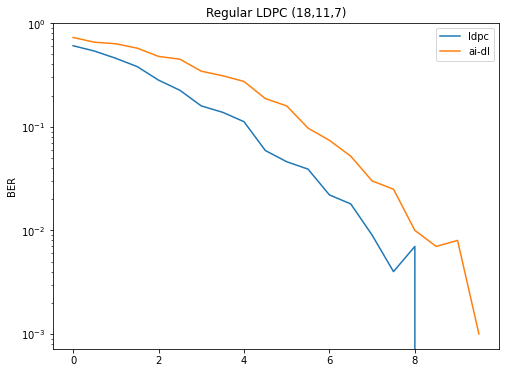

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(num_of_channel * 2,input_message_length,num_of_channel * 2 - input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(num_of_channel * 2,input_message_length))
plt.legend ()
plt.show()

In [50]:
import numpy
testing_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE))
testing_input_message_one_hot = numpy.zeros((testing_input_message.size, 2**input_message_length))
testing_input_message_one_hot[numpy.arange(testing_input_message.size),testing_input_message] = 1
print(testing_input_message_one_hot)
print (testing_input_message_one_hot.shape)
print (testing_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 2048)
(1, 1000)


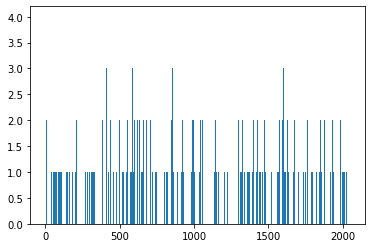

In [51]:
x_axis = numpy.arange(0,2**input_message_length)
plt.hist(testing_input_message[0], bins = x_axis) 
plt.show()

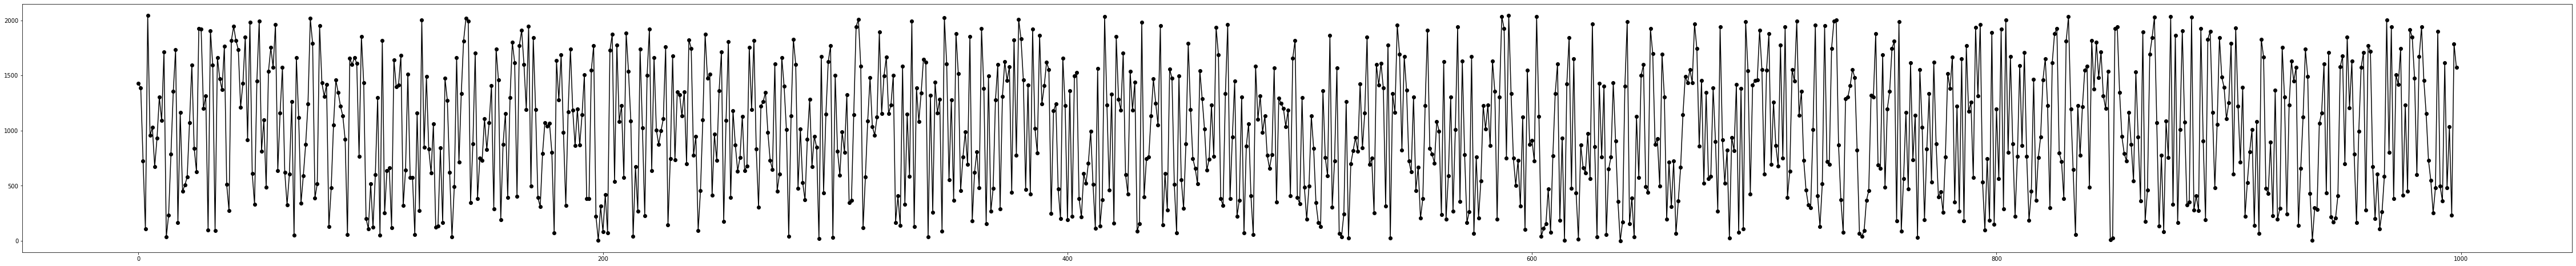

In [53]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:-1],training_input_message[0][:-1], '-ok')


In [54]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.29s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.60s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.93s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.26s
SNR: 0.000:
 -> BER: 0.77
 -> Total Time: 3.09s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.33s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.66s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.96s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.27s
SNR: 0.500:
 -> BER: 0.70
 -> Total Time: 3.22s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.32s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.64s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.97s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.30s
SNR: 1.000:
 -> BER: 0.65
 -> Total Time: 3.23s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.31s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.62s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

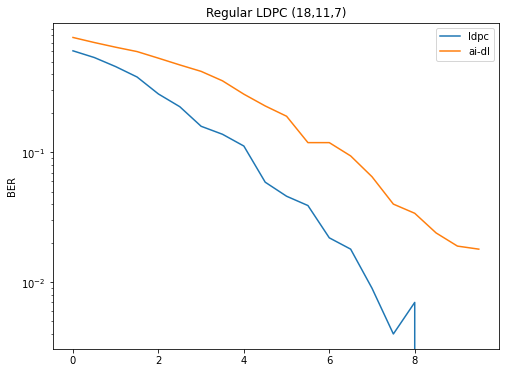

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(num_of_channel * 2,input_message_length,num_of_channel * 2 - input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(num_of_channel * 2,input_message_length))
plt.legend ()
plt.show()